# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import torch, torch.nn as nn
import torchvision as tv
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.functional as ttf
import torchvision.transforms as tt
from torchvision.io import decode_image
from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize 
from sklearn.model_selection import train_test_split, LearningCurveDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn import metrics

from tqdm import tqdm
import os
import copy
import utils

In [2]:
sns.set_theme(style="whitegrid", palette="Dark2")

# Constants

In [3]:
PATH = "data/images"

SEED = 10 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASSES = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
N_CLASSES = 5
CLASS_TO_NUM = {c:i for c,i in zip(CLASSES, range(N_CLASSES))}
NUM_TO_CLASS = {i:c for c,i in zip(CLASSES, range(N_CLASSES))}
TEST_SIZE = .2
TRAIN_SIZE = 1 - TEST_SIZE
BATCH_SIZE = 64
EPOCHS = 30
ML_EPOCHS = 500
LL_SAMPLES = 100

# Data Exploration & Processing

In [4]:
class RiceImageDataset(Dataset):
    def __init__(self, path_dir=PATH, classes=CLASSES, n_samples=1000, transform=None):
        self.path_dir = path_dir
        self.classes = classes
        self.transform = transform
        self.index_table = self._make_index_table(n_samples)
    def _make_index_table(self, n_samples):
        tab = pd.DataFrame()
        for i,c in enumerate(CLASSES) : 
            files = [f'{c}/{f}' for f in os.listdir(f'{self.path_dir}/{c}')]
            labels = [i]*len(files)
            tab = pd.concat([tab, pd.DataFrame([files[:n_samples], labels[:n_samples]]).T])
        return tab
    def __len__(self): return self.index_table.shape[0]
    def __getitem__(self, idx): 
        img_file, label =  self.index_table.iloc[idx]
        img = decode_image(f'{self.path_dir}/{img_file}')/255
        if self.transform : img = self.transform(img)
        return img, label
    
rice_data = RiceImageDataset(transform=tv.transforms.Resize((224,224)), n_samples=2500)
train_dataset, test_dataset = random_split(rice_data, [TRAIN_SIZE, TEST_SIZE], torch.Generator().manual_seed(SEED))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

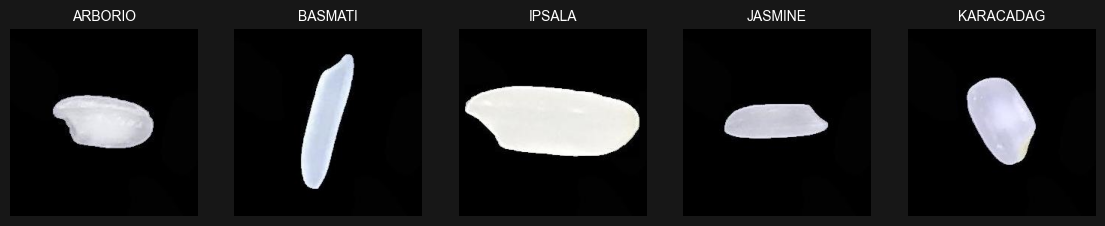

In [5]:
def view_data(dataset, path_dir=PATH, classes=CLASSES, size=(14,4)):
    fig, ax = plt.subplots(1, len(classes), figsize=size)
    for i,c in enumerate(classes):
        img = Image.open(path_dir+'/'+dataset.index_table[dataset.index_table[1]==i].iloc[0][0])
        ax[i].axis('off')
        ax[i].set_title(c.upper(), fontsize=10, color='white')
        ax[i].imshow(img)
    fig.patch.set_facecolor("#171717")

def view_data_examples(dataset, path_dir=PATH, classes=CLASSES, n_examples=10, size=[14,8]):
    fig, ax = plt.subplots(len(classes), n_examples, figsize=size)
    for i,c in enumerate(classes):
        for j in range(n_examples):
            img = Image.open(path_dir+'/'+dataset.index_table[dataset.index_table[1]==i].iloc[j][0])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            for spine in ax[i, j].spines.values():spine.set_visible(False)
            ax[i,j].imshow(img)
        ax[i,0].set_ylabel(c.upper(), fontsize=10, color='white')
    fig.patch.set_facecolor("#171717")

view_data(rice_data)

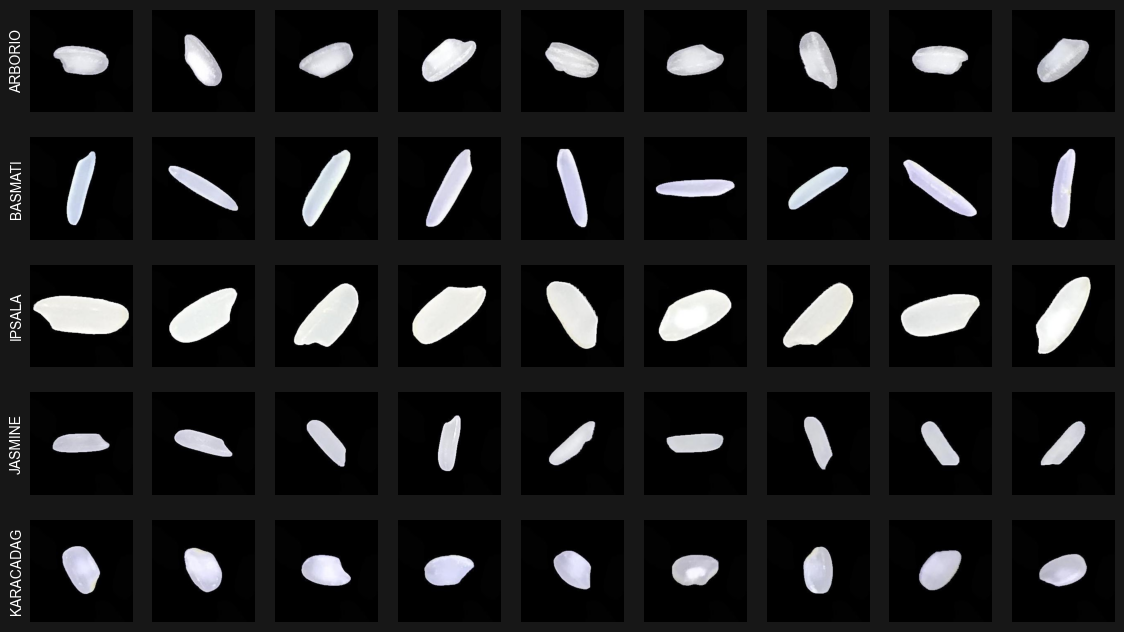

In [6]:
view_data_examples(rice_data, n_examples=9)

# Modeling 
### Transfer Learning with pretrained weights

In [7]:
class ResNetModel(nn.Module):
    def __init__(self, model, num_classes):
        super().__init__()
        self.model = model
        self.fc_channels = model.fc.in_features
        for p in self.model.parameters(): p.requires_grad=False # Freeze weights
        self.model.fc = nn.Identity()
        self.projection = self._create_projection_layer(num_classes)
    def _create_projection_layer(self, num_classes):
        return nn.Sequential(nn.Linear(self.fc_channels, self.fc_channels//2), nn.BatchNorm1d(self.fc_channels//2),
                             nn.ReLU(inplace=True), nn.Linear(self.fc_channels//2, num_classes))
    def forward(self, x): return self.projection(self.model(x))

class MobileNetModel(nn.Module):
    def __init__(self, model, num_classes):
        super().__init__()
        self.model = model
        self.fc_channels = model.classifier[-1].in_features
        for p in self.model.parameters(): p.requires_grad=False # Freeze weights
        self.model.classifier = nn.Identity()
        self.projection = self._create_projection_layer(num_classes)
    def _create_projection_layer(self, num_classes):
        return nn.Sequential(nn.Linear(self.fc_channels, self.fc_channels//2), nn.BatchNorm1d(self.fc_channels//2),
                             nn.ReLU(inplace=True), nn.Linear(self.fc_channels//2, num_classes))
    def forward(self, x): return self.projection(self.model(x))
    
clf_resnet = ResNetModel(tv.models.resnet18(weights='IMAGENET1K_V1'), N_CLASSES).to(DEVICE)
# clf_resnet = MobileNetModel(tv.models.mobilenet_v2(weights='IMAGENET1K_V2'), N_CLASSES).to(DEVICE)

In [8]:
def train_fn(train_loader, model, loss_fn, optimizer, progress=True):
    loop = tqdm(train_loader) if progress else train_loader
    accs, losses = [], []
    model.train()
    try :
        for batch_idx, (x,y) in enumerate(loop):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            y_pred = out.argmax(axis=1)
            accuracy = (y_pred==y).to(float).mean()
            accs.append(accuracy.item())
            loss = loss_fn(out,y)
            losses.append(loss.item())
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            if progress : loop.set_postfix(loss=loss.item(), accuracy=accuracy.item()) 
    except KeyboardInterrupt:
         print(f'Stopped at batch {batch_idx} with mean loss {sum(losses)/len(losses)} and accuracy {sum(accs)/len(accs)}')
    return model, sum(losses)/len(losses), sum(accs)/len(accs)
    
def test_fn(test_loader, model, loss_fn, progress=True, get_preds=False):
    loop = tqdm(test_loader) if progress else test_loader
    accs, losses = [], []
    y_test, y_preds = [], []
    model.eval()
    with torch.no_grad():
        for batch_idx, (x,y) in enumerate(loop):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            pred = out.argmax(axis=1)
            if get_preds:
                y_preds.append(out)
                y_test.append(y)
            accs.append((pred==y).to(float).mean().item())
            loss = loss_fn(out, y)
            losses.append(loss.item())
    return sum(losses)/len(losses), sum(accs)/len(accs), (torch.cat(y_preds), torch.cat(y_test)) if get_preds else None

def train_epochs(train_loader, test_loader, model, loss_fn, optimizer, epochs=EPOCHS, test=True, prog_train=True, prog_test=True):
    train_accs, train_losses, test_accs, test_losses = [], [], [], []
    loop = tqdm(range(epochs))
    # loop = range(epochs)
    for epoch in loop:
        model, train_loss, train_acc = train_fn(train_loader, model, loss_fn, optimizer, progress=prog_train)
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        if test : 
            test_loss, test_acc, _ = test_fn(test_loader, model, loss_fn, progress=prog_test)
            test_accs.append(test_acc)
            test_losses.append(test_loss)
        loop.set_postfix(loss=sum(train_losses)/len(train_losses), accuracy=sum(train_accs)/len(train_accs))
    return model, train_accs, train_losses, test_accs, test_losses

def save_model_and_metrics(model, metrics, model_name):
    metrics_data = pd.DataFrame({name: col for name, col in zip(['train_acc', 'train_loss', 'test_acc', 'test_loss'],metrics)})
    metrics_data.to_csv(model_name+'_metrics.csv')
    torch.save({"model": model.state_dict()}, model_name+'.pth.tar')


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_resnet.parameters(), weight_decay=1e-6)
clf_resnet, train_accs, train_losses, test_accs, test_losses = train_epochs(train_dataloader, test_dataloader, clf_resnet, loss_fn, optimizer, 
                                                                        epochs=EPOCHS, prog_train=False, prog_test=False)

100%|██████████| 30/30 [12:18<00:00, 24.61s/it, accuracy=0.995, loss=0.0146]


In [9]:
# save_model_and_metrics(clf_resnet, [train_accs, train_losses, test_accs, test_losses], 'clf_adam_batch64_ep20')

# Evaluation

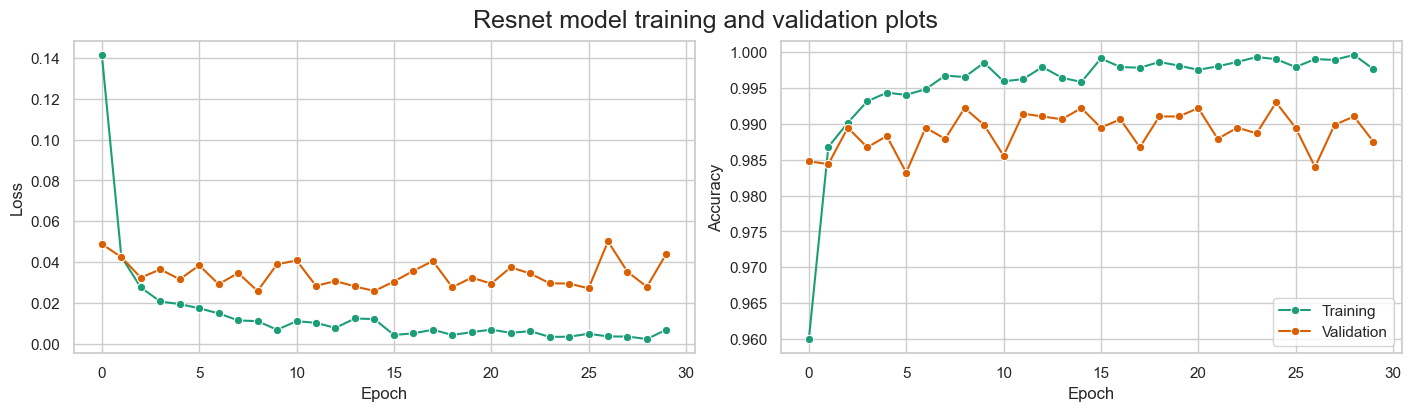

In [10]:
def plot_training(train_loss, test_loss, train_acc, test_acc, size=[14,4], title=''):
    fig, ax = plt.subplots(1,2, figsize=size, layout='constrained')
    sns.lineplot(ax=ax[0], data=train_loss, marker='o')
    sns.lineplot(ax=ax[0], data=test_loss, marker='o')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    sns.lineplot(ax=ax[1], data=train_acc, marker='o', label='Training')
    sns.lineplot(ax=ax[1], data=test_acc, marker='o', label='Validation')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='lower right')
    fig.suptitle(title, size=18)

plot_training(train_losses, test_losses, train_accs, test_accs, title='Resnet model training and validation plots')

100%|██████████| 40/40 [00:05<00:00,  6.91it/s]
c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(
c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


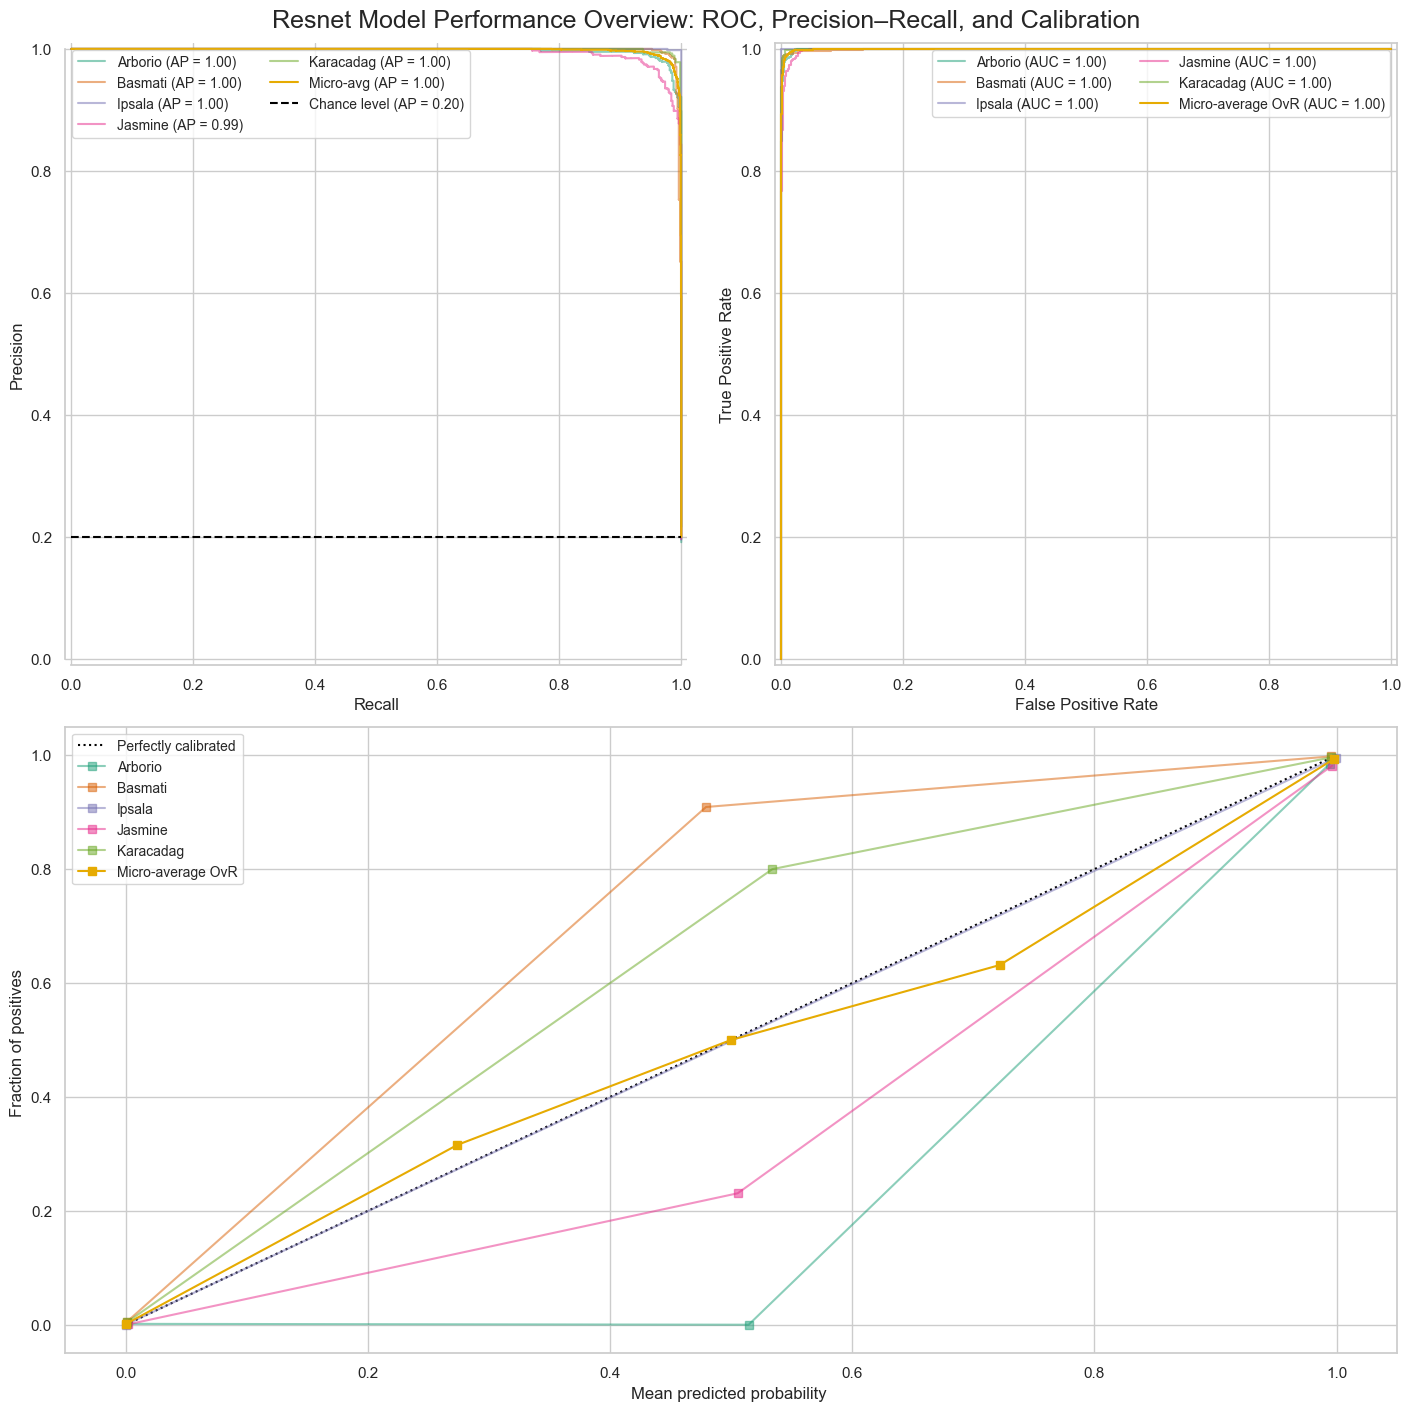

In [11]:
_, _, (y_score, y_test) = test_fn(test_dataloader, clf_resnet, loss_fn, get_preds=True)
utils.eval_summary(y_score.cpu(), torch.softmax(y_score, dim=1).cpu(), y_test.cpu(), title='Resnet Model Performance Overview: ROC, Precision–Recall, and Calibration')

# Loss Landscape

In [20]:
def get_one_batch(loader, device=DEVICE):
    """"""
    x,y = next(iter(loader))
    return x.to(device), y.to(device)

def get_direction_vectors(model):
    """"""
    u_vector = copy.deepcopy(model)
    v_vector = copy.deepcopy(model)
    with torch.no_grad():
        for p in u_vector.parameters(): p.copy_(torch.randn_like(p))
        for p in v_vector.parameters(): p.copy_(torch.randn_like(p))
        for pu, pv, p in zip(u_vector.parameters(), v_vector.parameters(), model.parameters()):
            pu_norm, pv_norm, p_norm = torch.norm(pu), torch.norm(pv), torch.norm(p)
            if pu_norm > 0 and p_norm > 0: pu.mul_(p_norm / pu_norm)
            if pv_norm > 0 and p_norm > 0: pv.mul_(p_norm / pv_norm)
    return u_vector, v_vector

def loss_landscape_fn(x, y, model, u_vector, v_vector, samples=LL_SAMPLES, classifier_only=False):
    """"""
    # original_params = [p.clone() for p in tmp_net.parameters()]
    loss_landscape = []
    with torch.no_grad():
        alpha_range = beta_range = torch.linspace(-1.5,1.5,samples)
        for a in tqdm(alpha_range):
            loss_beta = []
            for b in beta_range:
                tmp_net = copy.deepcopy(model) # needs optimization
                tmp_net.eval()
                if not classifier_only:
                    for p, pu, pv in zip(tmp_net.parameters(), u_vector.parameters(), v_vector.parameters()): p.add_(a*pu + b*pv)
                else :
                    for p, pu, pv in zip(tmp_net.projection.parameters(), u_vector.parameters(), v_vector.parameters()): p.add_(a*pu + b*pv)
                out = tmp_net(x.to(DEVICE))
                loss = loss_fn(out, y.to(DEVICE))
                loss_beta.append(loss.item())
            loss_landscape.append(loss_beta)
    return np.array(loss_landscape), alpha_range.numpy(), beta_range.numpy()

loss_landscape_full, alpha, beta = loss_landscape_fn(*get_one_batch(test_dataloader), clf_resnet, 
                                                     *get_direction_vectors(clf_resnet), samples=60)
loss_landscape_classifier, _, _ = loss_landscape_fn(*get_one_batch(train_dataloader), clf_resnet, 
                                                    *get_direction_vectors(clf_resnet.projection), classifier_only=True, samples=60)

100%|██████████| 60/60 [03:54<00:00,  3.90s/it]


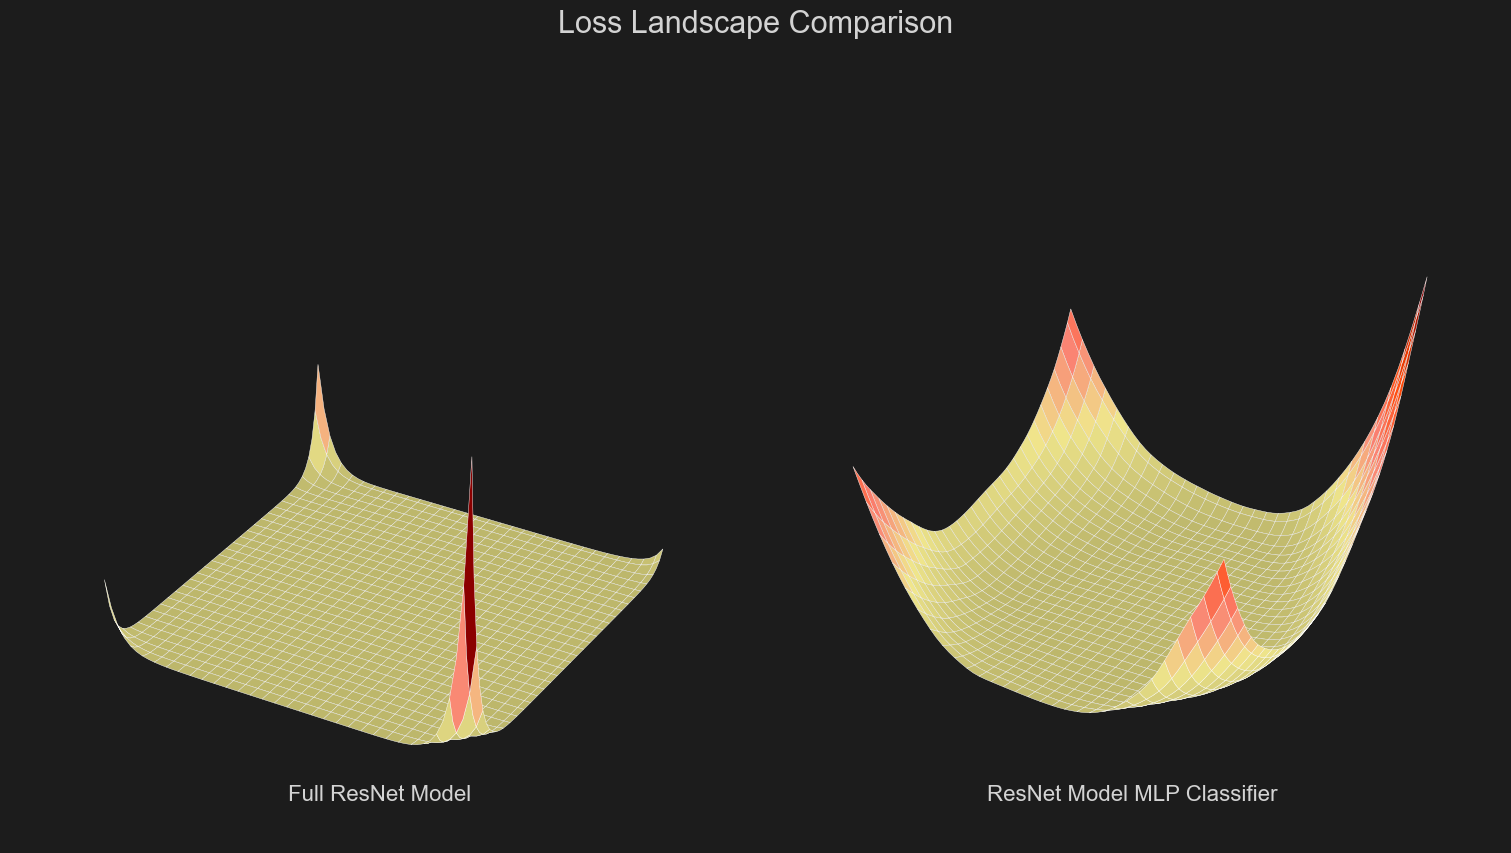

In [21]:
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(15,9), layout='constrained')
alpha_, beta_ = np.meshgrid(alpha, beta)
cmap = LinearSegmentedColormap.from_list("custom", ["darkred", "orangered", "salmon", "khaki", "darkkhaki"][::-1])
ax[0].plot_surface(alpha_, beta_, loss_landscape_full, linewidth=.3, cmap=cmap)
ax[1].plot_surface(alpha_, beta_, loss_landscape_classifier, linewidth=.3, cmap=cmap)
for a in ax : 
    a.set_facecolor('#1c1c1c')
    a.axis('off')
ax[0].set_title('Full ResNet Model', y=0.05, color='lightgray', size=16)
ax[1].set_title('ResNet Model MLP Classifier', y=0.05, color='lightgray', size=16)
fig.suptitle('Loss Landscape Comparison', color='lightgray', size=22)
fig.patch.set_facecolor('#1c1c1c')

# Classification using extracted features 

### Data Exploration

In [14]:
rice_pd = pd.read_excel('data/table/Rice_MSC_Dataset.xlsx')
print(rice_pd.isna().sum().sum())
rice_pd.dropna(inplace=True)
rice_pd

22


,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,ALLdaub4L,ALLdaub4a,ALLdaub4b,ALLdaub4Y,ALLdaub4Cb,ALLdaub4Cr,ALLdaub4XX,ALLdaub4YY,ALLdaub4ZZ,CLASS
0,7805,437.915,209.8215,48.0221,0.9735,99.6877,0.9775,7985,0.3547,4.3693,...,113.9924,65.0610,59.5989,104.8552,67.8779,63.0828,0.3673,0.3793,0.4733,Basmati
1,7503,340.757,138.3361,69.8417,0.8632,97.7400,0.9660,7767,0.6637,1.9807,...,105.7055,64.3685,62.2084,96.8375,65.5371,63.5832,0.3014,0.3144,0.3641,Arborio
2,5124,314.617,141.9803,46.5784,0.9447,80.7718,0.9721,5271,0.4760,3.0482,...,109.7155,62.6423,58.7439,100.2352,68.9753,59.8342,0.3233,0.3445,0.4448,Jasmine
3,7990,437.085,201.4386,51.2245,0.9671,100.8622,0.9659,8272,0.6274,3.9325,...,116.5405,64.9069,60.2562,107.2560,67.3298,63.2237,0.3880,0.4020,0.4904,Basmati
4,7433,342.893,140.3350,68.3927,0.8732,97.2830,0.9831,7561,0.6006,2.0519,...,107.7502,64.7071,61.3549,98.8704,66.2048,63.5378,0.3184,0.3303,0.3928,Arborio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,5551,285.911,114.1695,62.9079,0.8345,84.0699,0.9846,5638,0.6418,1.8149,...,103.9529,64.9225,62.4355,95.2780,65.5114,64.4457,0.2895,0.2997,0.3455,Arborio
74996,7696,322.703,121.3900,81.1375,0.7438,98.9892,0.9868,7799,0.7309,1.4961,...,108.9778,65.4571,59.9502,100.2301,67.5089,63.6028,0.3335,0.3426,0.4257,Karacadag
74997,7579,339.295,136.3125,71.2866,0.8524,98.2338,0.9805,7730,0.6399,1.9122,...,106.0881,64.1869,61.3876,97.1585,66.2445,63.0596,0.3028,0.3164,0.3761,Arborio
74998,15174,489.502,200.9486,97.6282,0.8740,138.9969,0.9766,15537,0.7903,2.0583,...,119.2037,63.3545,64.8200,109.3027,63.3122,63.5967,0.3970,0.4215,0.4469,Ipsala


In [15]:
def view_boxplots(d=pd.DataFrame(), x=[], y=None, r=6, c=6, size=[26,12], width=.8, outlier_size=4, title='', legend=[]):
    """"""
    fig, ax = plt.subplots(r, c, figsize=size, constrained_layout=True)
    ranges = [(i,j) for i in range(r) for j in range(c)]
    for xi,(i,j) in zip(x,ranges):
        sns.boxplot(ax=ax[i,j], data=d, x=xi, y=y, orient='h', hue=y, fliersize=outlier_size, legend=legend, width=width, palette='Set2')
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].legend_.remove()
    for k in range(len(x), r*c): ax[*ranges[k]].axis('off')
    handles, labels = ax[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=12, loc='lower right')
    fig.suptitle(title, size=18)

# view_boxplots(rice_pd, x=rice_pd.columns[:-1], y='CLASS', r=14, c=8, size=[24,22], legend=list(rice_pd.CLASS.unique()), outlier_size=2, width=.6)

### Data Processing

In [16]:
def find_minor_features(data, thresh=.3, show=False):
    scaler = StandardScaler()
    scaler.fit(data.drop(columns=['CLASS']))
    data_ = scaler.transform(data.drop(columns=['CLASS']))
    data_ = pd.concat([pd.DataFrame(data_, columns=rice_pd.columns[:-1]), data.CLASS.reset_index(drop=True)], axis=1)
    feats = data_.groupby('CLASS').mean().std().sort_values()
    feats = feats/feats.max()
    if show : print(feats)
    return feats[feats<thresh].index

minor_features = find_minor_features(rice_pd, thresh=.6)
minor_features

Index(['kurtosisCr', 'skewCr', 'kurtosisH', 'kurtosisA', 'StdDevH',
       'kurtosisCb', 'kurtosisB', 'kurtosisS', 'skewH', 'entropyH', 'StdDevCr',
       'skewZZ', 'ALLdaub4Cr', 'meanCr', 'SHAPEFACTOR_4', 'SOLIDITY',
       'entropyZZ', 'meanRB', 'ALLdaub4RB', 'meanZZ', 'ALLdaub4ZZ'],
      dtype='object')

In [17]:
features, target = rice_pd[rice_pd.columns[:-1]], rice_pd.CLASS.map(CLASS_TO_NUM) 
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, random_state=SEED)
x_train

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,ALLdaub4V,ALLdaub4L,ALLdaub4a,ALLdaub4b,ALLdaub4Y,ALLdaub4Cb,ALLdaub4Cr,ALLdaub4XX,ALLdaub4YY,ALLdaub4ZZ
65838,5612,325.356,143.4234,51.0725,0.9344,84.5306,0.9689,5792,0.6607,2.8082,...,0.4347,107.5027,64.5157,61.0126,98.5444,66.7834,63.1205,0.3133,0.3259,0.3927
22503,9372,441.434,206.8272,58.4093,0.9593,109.2374,0.9824,9540,0.8495,3.5410,...,0.4681,115.8889,60.1420,61.3184,105.4697,66.8377,58.4484,0.3578,0.3942,0.4658
40775,6440,393.800,187.1397,43.9459,0.9720,90.5520,0.9766,6594,0.5213,4.2584,...,0.4636,109.2394,65.4966,58.0940,100.4774,69.2065,62.8151,0.3343,0.3425,0.4496
44924,7726,343.710,133.9364,74.4794,0.8311,99.1819,0.9688,7975,0.6541,1.7983,...,0.4510,112.9824,64.4401,61.9985,103.7857,65.6762,63.5720,0.3581,0.3735,0.4323
63235,7031,316.145,126.4193,71.1343,0.8267,94.6158,0.9868,7125,0.7500,1.7772,...,0.4215,101.5341,65.6237,59.2962,93.2124,68.0697,63.4471,0.2771,0.2833,0.3639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17906,8717,411.689,182.8339,62.8868,0.9390,105.3510,0.9653,9030,0.6036,2.9074,...,0.4666,116.4931,60.9368,61.9911,106.2906,66.1390,59.6182,0.3690,0.4028,0.4656
37602,7663,344.809,138.9424,71.6174,0.8569,98.7767,0.9723,7881,0.7298,1.9401,...,0.4289,109.7632,64.1141,63.1366,100.5985,64.7971,63.8514,0.3297,0.3455,0.3871
10201,7571,417.074,195.5233,50.1826,0.9665,98.1820,0.9749,7766,0.4440,3.8962,...,0.4677,109.7306,65.4510,57.8293,100.9295,69.4671,62.6463,0.3381,0.3464,0.4583
9372,6355,299.596,113.2946,72.4247,0.7690,89.9524,0.9725,6535,0.7368,1.5643,...,0.4230,100.9694,65.4372,58.6818,92.6455,68.5178,62.9730,0.2728,0.2794,0.3658


### Modeling & Evaluation

              precision    recall  f1-score   support

     Arborio     0.9980    0.9970    0.9975      2975
     Basmati     0.9987    0.9977    0.9982      3077
      Ipsala     1.0000    1.0000    1.0000      3015
     Jasmine     0.9956    0.9976    0.9966      2948
   Karacadag     0.9987    0.9987    0.9987      2984

    accuracy                         0.9982     14999
   macro avg     0.9982    0.9982    0.9982     14999
weighted avg     0.9982    0.9982    0.9982     14999



c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(
c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


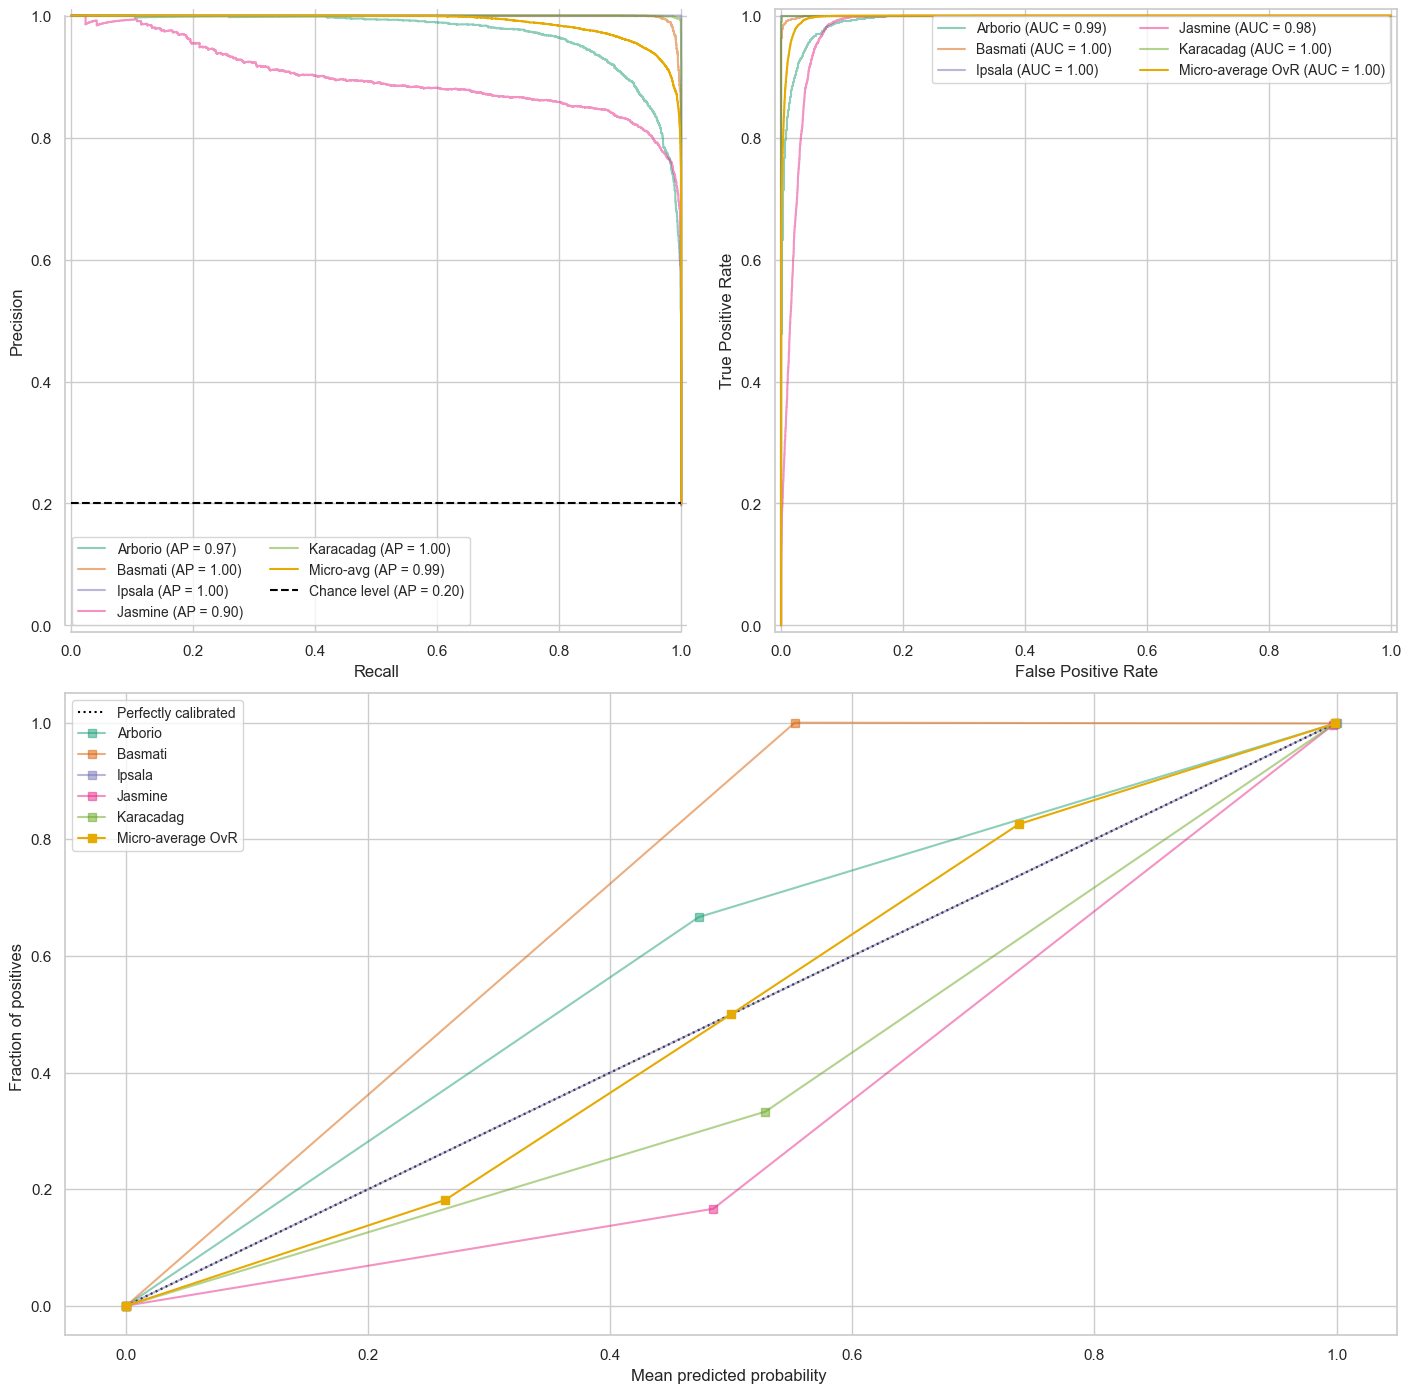

In [18]:
def train_ml(model_name, x_train, y_train, scaling=True, **kwargs):
    x_train_ = x_train.copy()
    if scaling :
        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train_ = scaler.transform(x_train_)
    model = model_name(**kwargs)
    model.fit(x_train_, y_train)
    return model, x_train_, y_train, scaler if scaling else None

clf_logit, x_train_, y_train_, scaler = train_ml(LogisticRegression, x_train, y_train, max_iter=ML_EPOCHS, penalty='l2')
print(metrics.classification_report(y_test, clf_logit.predict(scaler.transform(x_test)), 
                                    labels=list(range(N_CLASSES)), target_names=CLASSES, digits=4))
y_proba = clf_logit.predict_proba(scaler.transform(x_test))
y_score = clf_logit.decision_function(scaler.transform(x_test))
utils.eval_summary(y_score, y_proba, y_test)

#### Enhancing model (reduced dimensionality) 

              precision    recall  f1-score   support

     Arborio     0.9987    0.9973    0.9980      2975
     Basmati     0.9984    0.9971    0.9977      3077
      Ipsala     1.0000    0.9997    0.9998      3015
     Jasmine     0.9949    0.9983    0.9966      2948
   Karacadag     0.9990    0.9987    0.9988      2984

    accuracy                         0.9982     14999
   macro avg     0.9982    0.9982    0.9982     14999
weighted avg     0.9982    0.9982    0.9982     14999



c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(
c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


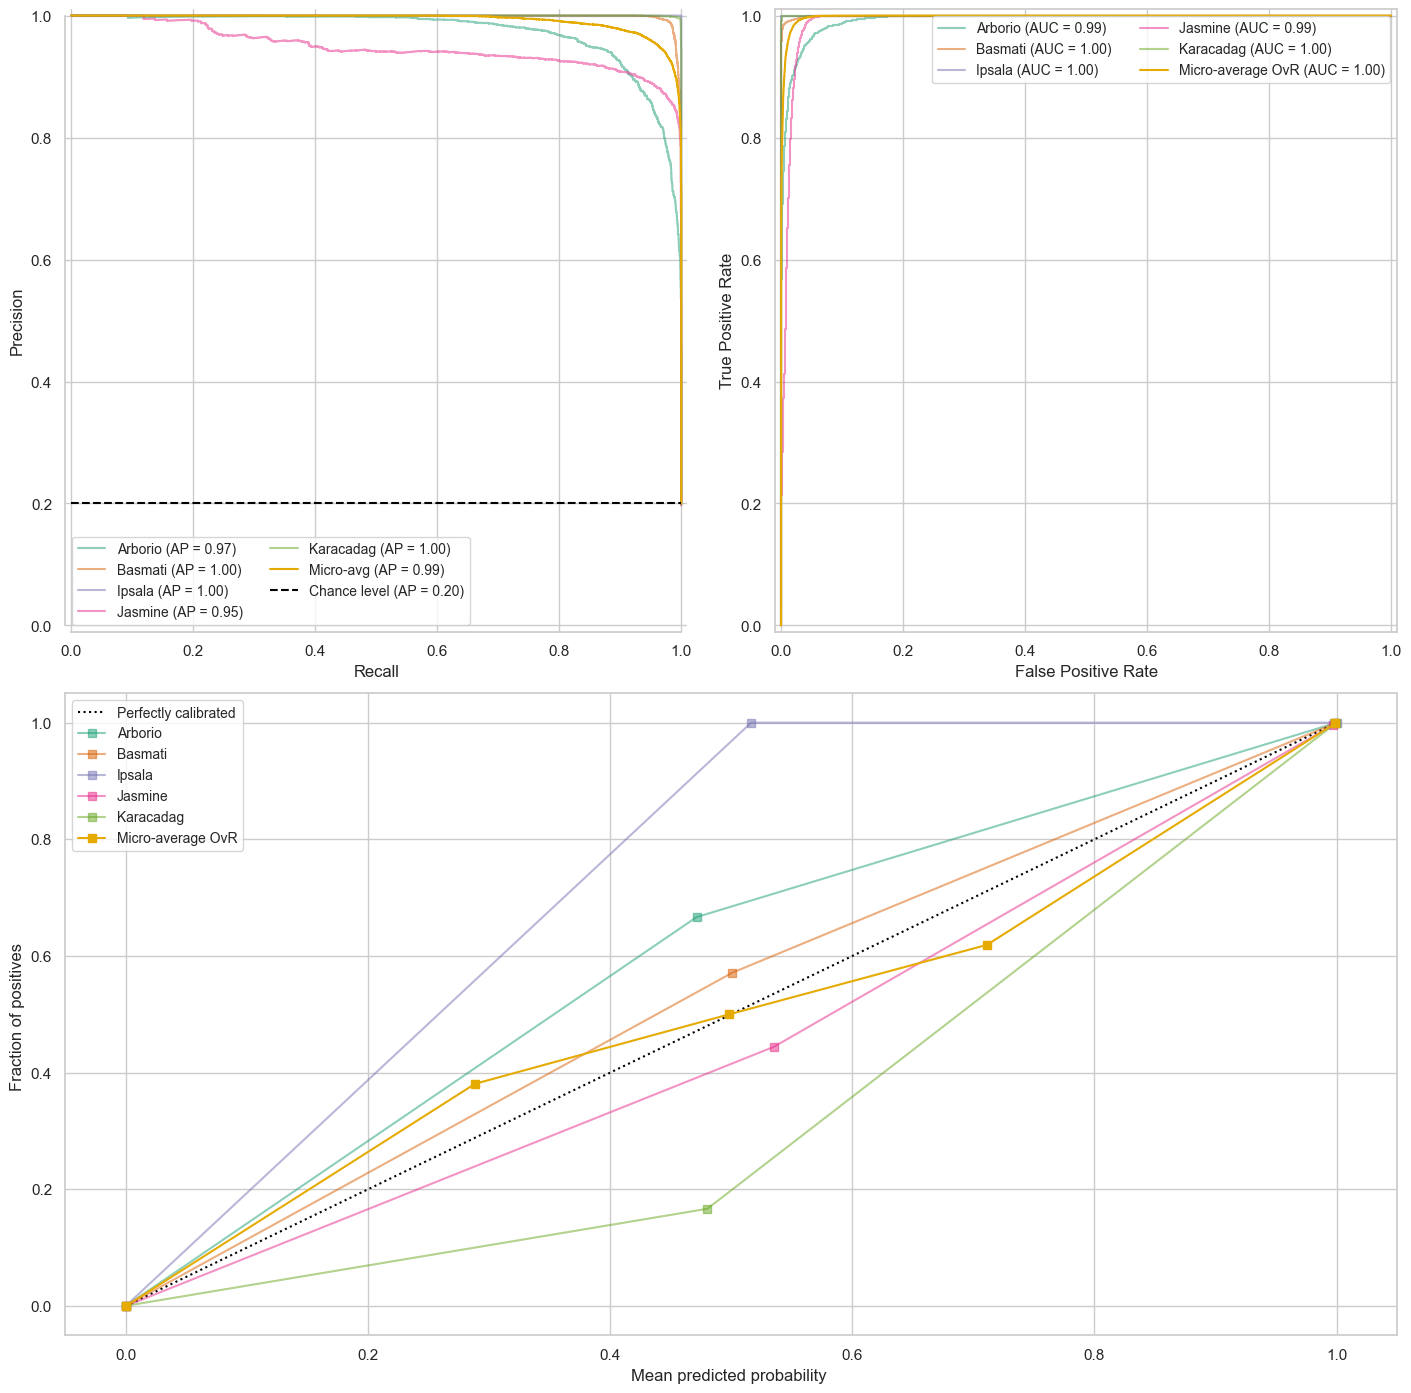

In [19]:
clf_logit, x_train_, y_train_, scaler = train_ml(LogisticRegression, x_train.drop(columns=minor_features), y_train, max_iter=ML_EPOCHS, penalty='l2')
print(metrics.classification_report(y_test, clf_logit.predict(scaler.transform(x_test.drop(columns=minor_features))), 
                                    labels=list(range(N_CLASSES)), target_names=CLASSES, digits=4))
y_proba = clf_logit.predict_proba(scaler.transform(x_test.drop(columns=minor_features)))
y_score = clf_logit.decision_function(scaler.transform(x_test.drop(columns=minor_features)))
utils.eval_summary(y_score, y_proba, y_test)